In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ['RELIANCE.NS', 'INFY.NS', 'ICICIBANK.NS']
data = yf.download(tickers, start='2020-01-01', end='2025-05-31', interval='1mo')['Close']
returns = data.pct_change().dropna()

returns

/tmp/ipython-input-4131273232.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2025-05-31', interval='1mo')['Close']
[*********************100%***********************]  3 of 3 completed


Ticker,ICICIBANK.NS,INFY.NS,RELIANCE.NS
Date,,,
2020-02-01,-0.054029,-0.057027,-0.058796
2020-03-01,-0.348919,-0.123275,-0.161743
2020-04-01,0.174208,0.115355,0.316274
2020-05-01,-0.126792,-0.034242,0.008377
2020-06-01,0.058744,0.079548,0.163685
...,...,...,...
2025-01-01,-0.022510,-0.000106,0.040849
2025-02-01,-0.038873,-0.102192,-0.051379
2025-03-01,0.119799,-0.069355,0.062495


In [2]:
d = {'Expected_Returns':[float(returns[i].mean()) for i in tickers],'Volatility':[float(returns[i].std()) for i in tickers]}
df = pd.DataFrame(d)
df.index = tickers
df

,Expected_Returns,Volatility
RELIANCE.NS,0.015625,0.079418
INFY.NS,0.016128,0.082034
ICICIBANK.NS,0.019950,0.082743


In [3]:
cov = {}
for i in tickers:
  L = []
  for j in tickers:
    I = list(returns[i])
    J = list(returns[j])
    mean_I = sum(I)/len(I)
    mean_J = sum(J)/len(J)
    l = [(I[k] - mean_I)*(J[k] - mean_J) for k in range(len(J))]
    L.append(sum(l)/len(l))
  cov[i] = L
cov_df = pd.DataFrame(cov)
cov_df.index = tickers
cov_df

,RELIANCE.NS,INFY.NS,ICICIBANK.NS
RELIANCE.NS,0.006209,0.002574,0.002631
INFY.NS,0.002574,0.006624,0.001269
ICICIBANK.NS,0.002631,0.001269,0.006739


In [4]:
weights = [[0.15990036003080643, 0.4354754413085217],
 [0.03630236917844726, 0.25942641577411746],
 [0.25433152581222473, 0.2923861793697022],
 [0.3772546271374454, 0.25087254659258645],
 [0.463887777985488, 0.490938807437021]]

In [5]:
for i in range(len(weights)):
  weights[i].append(1 - weights[i][0] - weights[i][1])
weights

[[0.15990036003080643, 0.4354754413085217, 0.40462419866067184],
 [0.03630236917844726, 0.25942641577411746, 0.7042712150474353],
 [0.25433152581222473, 0.2923861793697022, 0.4532822948180731],
 [0.3772546271374454, 0.25087254659258645, 0.37187282626996815],
 [0.463887777985488, 0.490938807437021, 0.04517341457749102]]

In [6]:
d2 = {}
for i in range(1,6):
  d2[f'Portfolio{i}'] = weights[i-1]
portfolios = pd.DataFrame(d2)
portfolios.index = tickers
portfolios

,Portfolio1,Portfolio2,Portfolio3,Portfolio4,Portfolio5
RELIANCE.NS,0.159900,0.036302,0.254332,0.377255,0.463888
INFY.NS,0.435475,0.259426,0.292386,0.250873,0.490939
ICICIBANK.NS,0.404624,0.704271,0.453282,0.371873,0.045173


In [7]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

In [8]:
portfolio_returns = []
for i in range(5):
  weights = list(portfolios[f'Portfolio{i+1}'])
  r = 0
  for i in range(3):
    r+=float(weights[i]*(returns[tickers[i]].mean()))
  portfolio_returns.append(r)
portfolio_std = []
for i in range(5):
  weights = list(portfolios[f'Portfolio{i+1}'])
  s = 0
  for i in range(3):
    s+=float(weights[i]*((returns[tickers[i]].std())**2))
  portfolio_std.append(float(np.sqrt(s)))
sharpe = []
for i in range(5):
  sharpe.append((portfolio_returns[i]*len(returns) - 0.06)/(portfolio_std[i]*float(np.sqrt(len(returns)))))

In [9]:
d3 = {'Expected_Returns(Monthly)':portfolio_returns,'Standard_Deviation':portfolio_std,'Sharpe_Ratio':sharpe}
port_perform = pd.DataFrame(d3)
port_perform.index = [f'Portfolio{i+1}' for i in range(5)]
port_perform

,Expected_Returns(Monthly),Standard_Deviation,Sharpe_Ratio
Portfolio1,0.017594,0.081910,1.626805
Portfolio2,0.018801,0.082441,1.733496
Portfolio3,0.017732,0.081701,1.644519
Portfolio4,0.017359,0.081324,1.615445
Portfolio5,0.016067,0.080863,1.496820


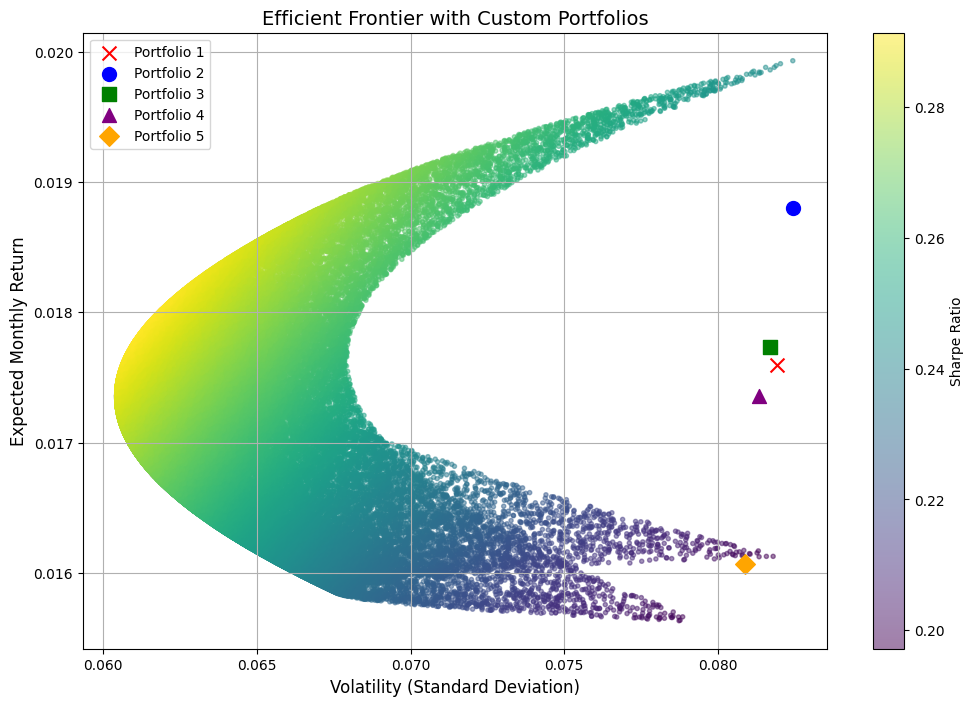

In [10]:
# Calculate mean returns and covariance matrix
mean_returns = returns.mean().values
cov_matrix = returns.cov().values

# Efficient Frontier Simulation
num_portfolios = 100000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = port_return / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio

# Convert results to DataFrame
results_df = pd.DataFrame(results.T, columns=["Return", "Volatility", "Sharpe"])

# Plotting Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', marker='.', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Expected Monthly Return', fontsize=12)
plt.title('Efficient Frontier with Custom Portfolios', fontsize=14)

markers = ['x', 'o', 's', '^', 'D']
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i in range(5):
    plt.scatter(
        portfolio_std[i],
        portfolio_returns[i],
        color=colors[i],
        marker=markers[i],
        s=100,
        label=f'Portfolio {i+1}'
    )

plt.legend()
plt.grid(True)
plt.show()


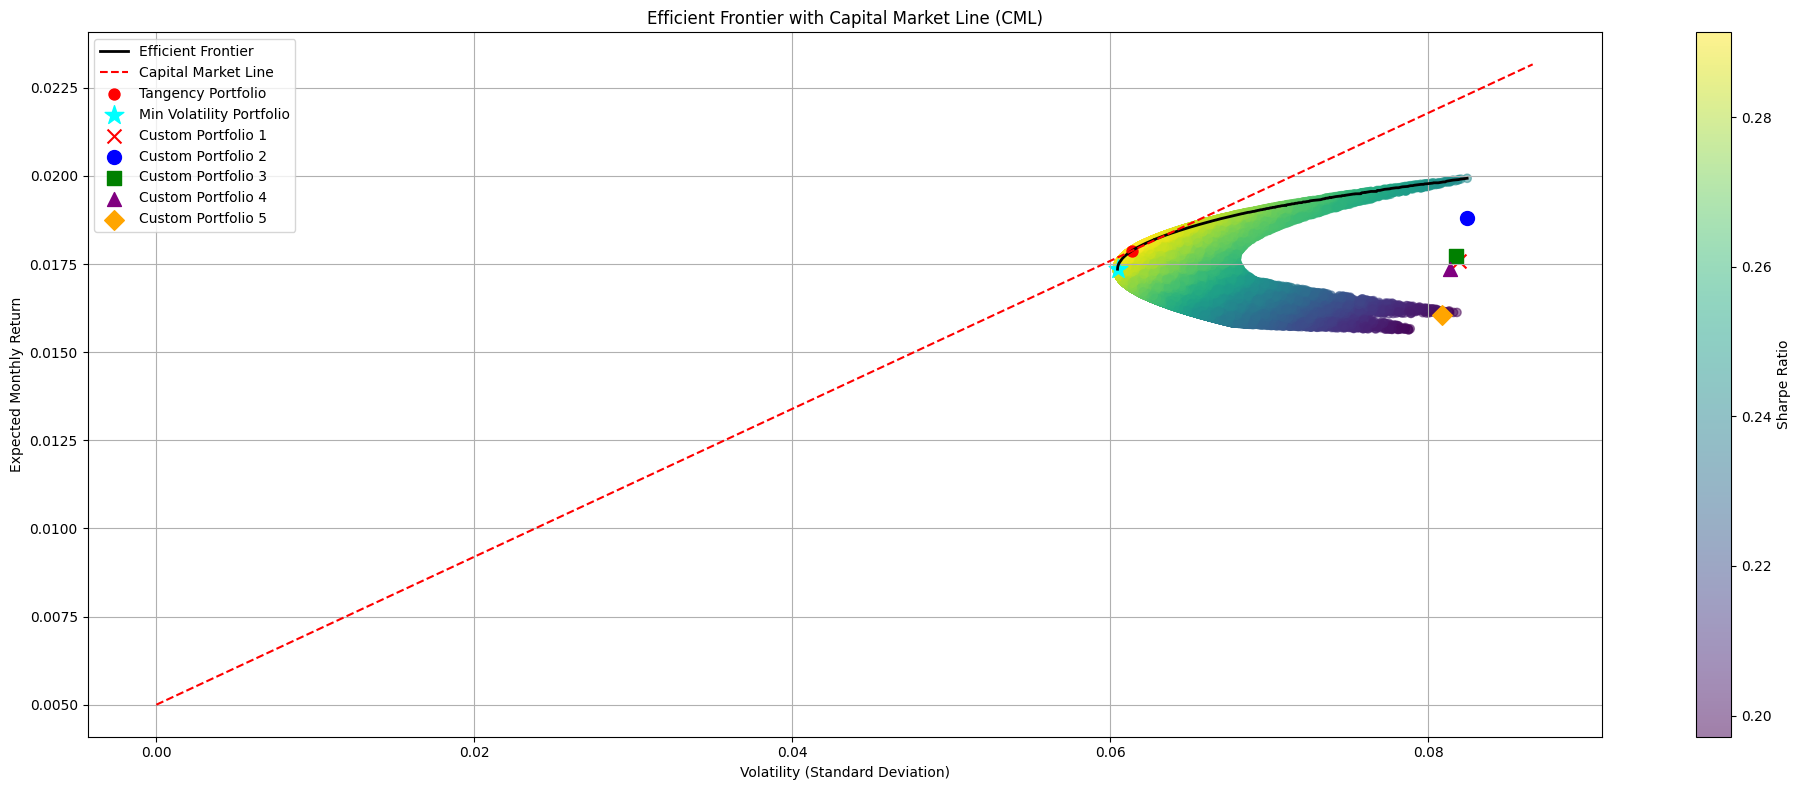

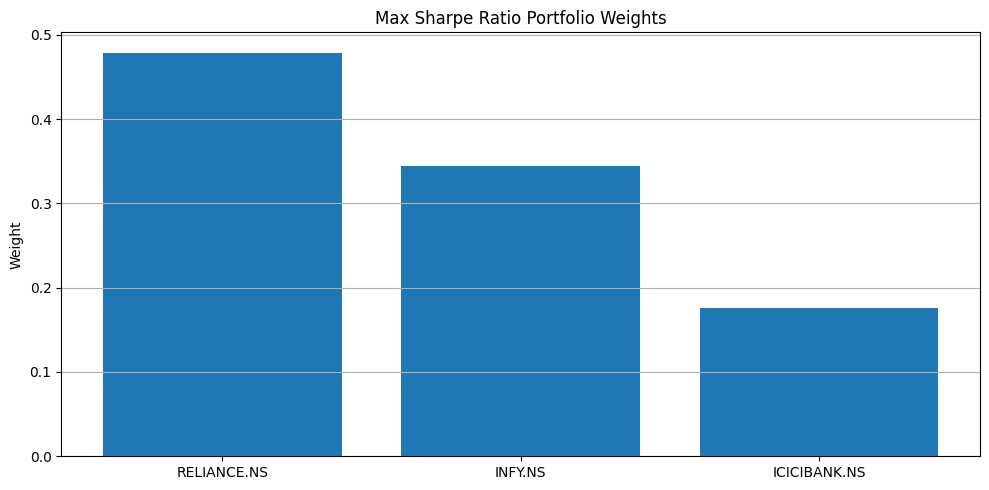

Max Sharpe Ratio Portfolio Weights (%):
----------------------------------------
RELIANCE.NS :  47.90 %
INFY.NS     :  34.46 %
ICICIBANK.NS:  17.65 %


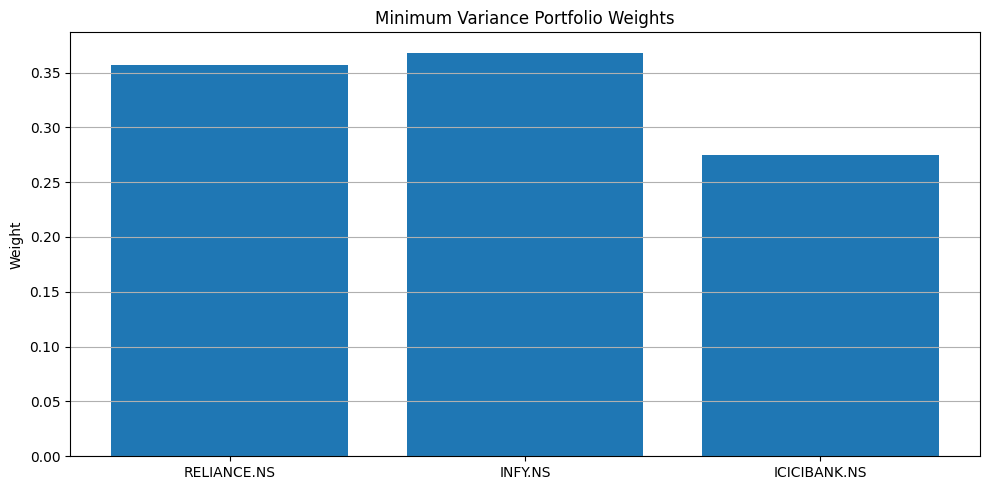

Minimum Variance Portfolio Weights (%):
----------------------------------------
RELIANCE.NS :  35.68 %
INFY.NS     :  36.83 %
ICICIBANK.NS:  27.50 %


In [11]:
returns = results_df['Return']
risks = results_df['Volatility']
sharpe_ratios = results_df['Sharpe']
rf = 0.005

# key portfolios
max_sharpe_idx = np.argmax(sharpe_ratios)
tangent_return = returns[max_sharpe_idx]
tangent_risk = risks[max_sharpe_idx]
min_var_idx = np.argmin(risks)
min_vol_return = returns[min_var_idx]
min_vol_risk = risks[min_var_idx]

# Efficient Frontier with Capital Market Line, Upper Boundary and Custom Portfolios
sorted_idx = np.argsort(risks)
efficient_risks = []
efficient_returns = []
prev_return = -np.inf
for idx in sorted_idx:
    if returns[idx] > prev_return:
        efficient_risks.append(risks[idx])
        efficient_returns.append(returns[idx])
        prev_return = returns[idx]

# --- Plot 1: Efficient Frontier, CML, All Portfolios ---

plt.figure(figsize=(20, 8))
sc = plt.scatter(risks, returns, c=sharpe_ratios, cmap='viridis', alpha=0.5)
plt.plot(efficient_risks, efficient_returns, color='black', linewidth=2, label='Efficient Frontier')
plt.colorbar(sc, label='Sharpe Ratio')


# Plot Capital Market Line
x = np.linspace(0, max(risks)*1.05, 100)
cml = rf + (tangent_return - rf) / tangent_risk * x
plt.plot(x, cml, 'r--', label='Capital Market Line')

# Mark Tangency and Min Volatility Portfolios
plt.scatter(tangent_risk, tangent_return, color='red', marker='.', s=250, label='Tangency Portfolio')
plt.scatter(min_vol_risk, min_vol_return, c='cyan', marker='*', s=200, label='Min Volatility Portfolio')

# Mark Custom Portfolios
markers = ['x', 'o', 's', '^', 'D']
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(5):
    plt.scatter(
        portfolio_std[i],
        portfolio_returns[i],
        color=colors[i],
        marker=markers[i],
        s=100,
        label=f'Custom Portfolio {i+1}'
    )

plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Monthly Return')
plt.title('Efficient Frontier with Capital Market Line (CML)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Max Sharpe Portfolio Weights ---

plt.figure(figsize=(10, 5))
plt.bar(tickers, weights_record[max_sharpe_idx])
plt.title('Max Sharpe Ratio Portfolio Weights')
plt.ylabel('Weight')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Max Sharpe Ratio Portfolio Weights (%):\n" + "-" * 40)
for ticker, weight in zip(tickers, weights_record[max_sharpe_idx]):
    print(f"{ticker:<12}: {weight * 100:6.2f} %")


# --- Min Variance Portfolio Weights ---

plt.figure(figsize=(10, 5))
plt.bar(tickers, weights_record[min_var_idx])
plt.title('Minimum Variance Portfolio Weights')
plt.ylabel('Weight')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Minimum Variance Portfolio Weights (%):\n" + "-" * 40)
for ticker, weight in zip(tickers, weights_record[min_var_idx]):
    print(f"{ticker:<12}: {weight * 100:6.2f} %")
